In [1]:
!pip install census

In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census

# Census API Key
from config import api_key
#c = Census(api_key, year=2016)

In [3]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
def get_census(year):
    c = Census(api_key, year=year)
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), 
                         {'for': 'county:*'})
                        # {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

# Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "county": "County"
                                      })

# Add in Poverty Rate (Poverty Count / Population)
    census_pd["Poverty Rate"] = 100 * \
        census_pd["Poverty Count"].astype(
            int) / census_pd["Population"].astype(int)

# Final DataFrame
    census_pd = census_pd[["Name","County", "Population", "Median Age", "Household Income",
                           "Per Capita Income", "Poverty Count", "Poverty Rate"]]

    census_pd['county_name'] = census_pd['Name'].str.replace(r" County,(.*)",'').str.upper()
    census_pd['state'] = census_pd['Name'].str.replace(r"(.*) County, ",'').str.upper()
# Visualize
    
    return census_pd

census_2016 = get_census(2016)
census_2016.head()
census_2016['year'] = 2016

census_2020 = get_census(2020)
census_2020['year'] = 2020
census_2020.head()
census = pd.concat([census_2016,census_2020])

C:\Users\Sridevi\AppData\Local\Temp/ipykernel_15568/1925853534.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  census_pd['county_name'] = census_pd['Name'].str.replace(r" County,(.*)",'').str.upper()
C:\Users\Sridevi\AppData\Local\Temp/ipykernel_15568/1925853534.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  census_pd['state'] = census_pd['Name'].str.replace(r"(.*) County, ",'').str.upper()


In [4]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
winners_pd=pd.read_csv("countypres_2000-2020.csv")
winners_pd = winners_pd[((winners_pd['year'] == 2016) | (winners_pd['year'] == 2020)) & (winners_pd['mode'] == 'TOTAL')]
dem_pd = winners_pd[winners_pd['party'] == 'DEMOCRAT']
dem_pd
 #& ((winners_pd['party'] == 'DEMOCRAT') | (winners_pd['party'] == 'REPUBLICAN') )
rep_pd = winners_pd[winners_pd['party'] == 'REPUBLICAN']
rep_pd

merge_pd=dem_pd.merge(rep_pd, on = ['year','state', 'county_name'])

merge_pd[merge_pd['county_name']=='BALDWIN']
dem_pd
#rep_pd
merge_pd['winner'] = np.where(merge_pd['candidatevotes_x'] > merge_pd['candidatevotes_y'], merge_pd['party_x'], merge_pd['party_y'])
merge_pd = merge_pd[['year','state','county_name','winner']]
merge_pd

,year,state,county_name,winner
0,2016,ALABAMA,AUTAUGA,REPUBLICAN
1,2016,ALABAMA,BALDWIN,REPUBLICAN
2,2016,ALABAMA,BARBOUR,REPUBLICAN
3,2016,ALABAMA,BIBB,REPUBLICAN
4,2016,ALABAMA,BLOUNT,REPUBLICAN
...,...,...,...,...
5469,2020,WYOMING,SWEETWATER,REPUBLICAN
5470,2020,WYOMING,TETON,DEMOCRAT
5471,2020,WYOMING,UINTA,REPUBLICAN
5472,2020,WYOMING,WASHAKIE,REPUBLICAN


In [6]:
cleaned_census_data = merge_pd.merge(census, on=['year','state', 'county_name'])

cleaned_census_data = cleaned_census_data[['year','state', 'county_name','Population','Median Age', 'Household Income', 'Per Capita Income', 'Poverty Rate', 'winner']]
cleaned_census_data

,year,state,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,winner
0,2016,ALABAMA,AUTAUGA,55049.0,37.8,53099.0,26168.0,12.165525,REPUBLICAN
1,2016,ALABAMA,BALDWIN,199510.0,42.3,51365.0,28069.0,12.806877,REPUBLICAN
2,2016,ALABAMA,BARBOUR,26614.0,38.7,33956.0,17249.0,23.427519,REPUBLICAN
3,2016,ALABAMA,BIBB,22572.0,40.2,39776.0,18988.0,15.018607,REPUBLICAN
4,2016,ALABAMA,BLOUNT,57704.0,40.8,46212.0,21033.0,16.361084,REPUBLICAN
...,...,...,...,...,...,...,...,...,...
5206,2020,WYOMING,SWEETWATER,43352.0,35.7,73384.0,34282.0,11.328197,REPUBLICAN
5207,2020,WYOMING,TETON,23356.0,40.3,87053.0,60331.0,6.499401,DEMOCRAT
5208,2020,WYOMING,UINTA,20374.0,36.0,72458.0,30442.0,9.472858,REPUBLICAN
5209,2020,WYOMING,WASHAKIE,7933.0,42.6,57306.0,30212.0,10.260935,REPUBLICAN


In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [8]:
X = cleaned_census_data.drop(['year','state', 'county_name','winner'], axis=1)
X.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate
0,55049.0,37.8,53099.0,26168.0,12.165525
1,199510.0,42.3,51365.0,28069.0,12.806877
2,26614.0,38.7,33956.0,17249.0,23.427519
3,22572.0,40.2,39776.0,18988.0,15.018607
4,57704.0,40.8,46212.0,21033.0,16.361084


In [9]:
y = cleaned_census_data["winner"].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler()
X_scaler.fit(X_train)

StandardScaler()

In [12]:
# Transform the training and testing data by using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 0.999/0.842
k: 3, Train/Test Score: 0.918/0.868
k: 5, Train/Test Score: 0.908/0.871
k: 7, Train/Test Score: 0.904/0.881
k: 9, Train/Test Score: 0.903/0.884
k: 11, Train/Test Score: 0.899/0.889
k: 13, Train/Test Score: 0.898/0.883
k: 15, Train/Test Score: 0.900/0.889
k: 17, Train/Test Score: 0.897/0.888
k: 19, Train/Test Score: 0.895/0.889


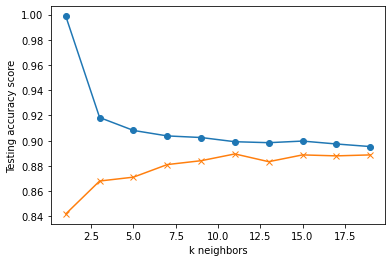

In [13]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [14]:
# Note that k: 11 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, y_train)
print('k=11 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=11 Test Acc: 0.889
